# Stock Market Prediction
***
## Table of Contents

***

In [1]:
import torch
import time
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import date
from torchinfo import summary
from torch import nn
from tqdm import tqdm
from typing import List, Tuple, Optional, Dict
from numpy.typing import NDArray
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

## 1. Introduction


## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

However, during the training process, I encountered several issues with LSTM networks on the MPS backend (e.g., error metrics became substantially higher compared to the CPU, etc.). Therefore, the CPU will be used throughout this project for '*safety*'.

**Reference**:
- [Training results from using MPS backend are poor compared to CPU and CUDA](https://github.com/pytorch/pytorch/issues/109457)
- [MPS backend produces bad training results in comparison to other backends](https://github.com/pytorch/pytorch/issues/92615)
- [Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)](https://github.com/pytorch/pytorch/issues/145374)

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device = torch.device("cpu")  # For Mac, safer device use
device

device(type='cpu')

## 3. Loading Dataset
This project will use yfinance API to fetch financial data from Yahoo! Finance. The default DataFrame has a two-level column index: `(column name, ticker)`, so the second level will be removed.

In [3]:
TICKER = "AAPL"  # Apple Inc. stock data
START_DATE = "2015-01-01"
END_DATE = date.today().strftime("%Y-%m-%d")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
df.columns = df.columns.droplevel(1)  # Drop the second level
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


In [4]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

Price           Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.288584  24.757338  23.848709  24.746230  212818400
2015-01-05  23.604334  24.137514  23.417722  24.057537  257142000
2015-01-06  23.606556  23.866481  23.244437  23.668760  263188400
2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600
2015-01-08  24.857306  24.915067  24.148620  24.266365  237458000
Shape of the dataset: (2661, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2661 entries, 2015-01-02 to 2025-08-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2661 non-null   float64
 1   High    2661 non-null   float64
 2   Low     2661 non-null   float64
 3   Open    2661 non-null   float64
 4   Volume  2661 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 124.7 KB
None
Count of null values: 0
Price        Close         High          L

In [5]:
FEATURES = list(range(len(df.columns)))  # All features
TARGET_INDEX = 0
TRAIN_SPLIT_RATE = 0.9
SEQUENCE_LENGTH = 90  # 90 days
BATCH_SIZE = 128
HIDDEN_SIZE = 256
INPUT_SIZE = len(FEATURES)
OUTPUT_SIZE = 1
N_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 10

## 4. Exploratory Data Analysis

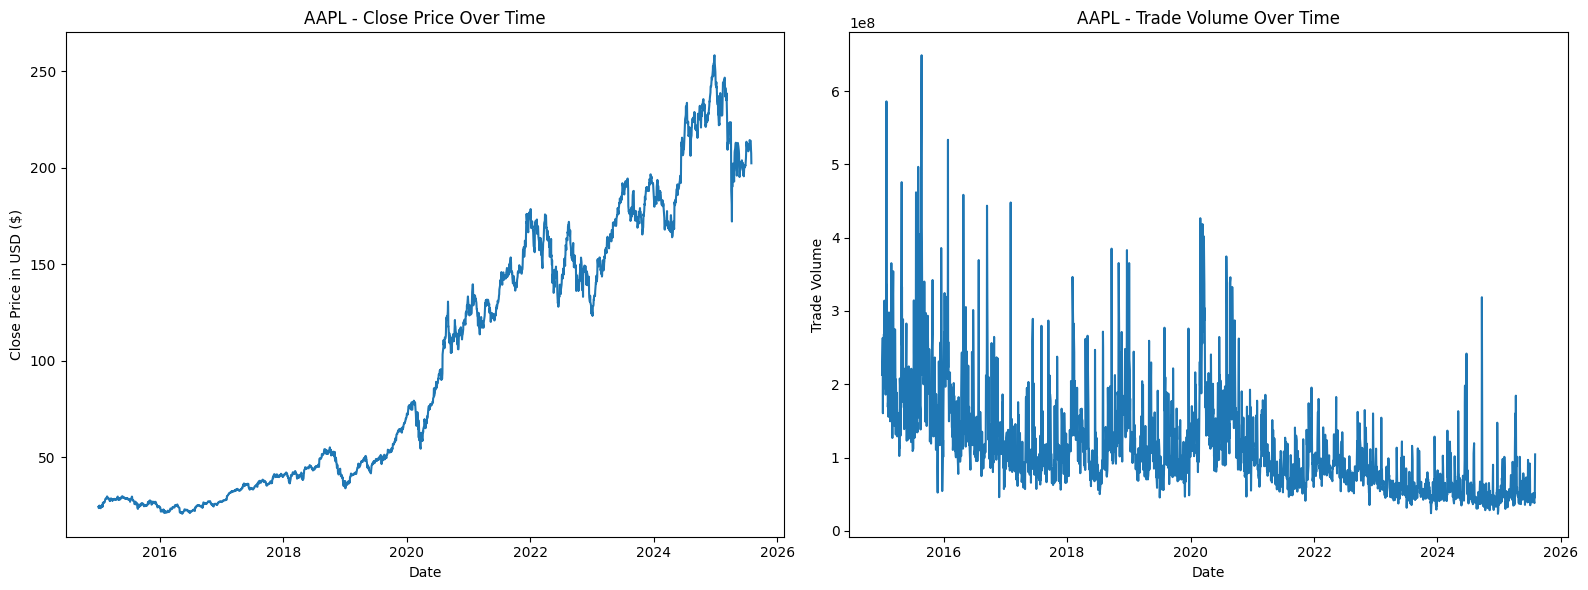

In [6]:
def plot_figures(df: pd.DataFrame, ticker: str) -> None:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    axes = axes.flatten()

    # 1st plot
    sns.lineplot(df, ax=axes[0], x=df.index, y="Close")
    axes[0].set_title(f"{ticker} - Close Price Over Time")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Close Price in USD ($)")

    # 2nd plot
    sns.lineplot(df, ax=axes[1], x=df.index, y="Volume")
    axes[1].set_title(f"{ticker} - Trade Volume Over Time")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Trade Volume")

    plt.tight_layout()
    plt.show()


plot_figures(df, TICKER)


## 5. Sliding Window Sequences
The following function generates sliding window sequences and their corresponding targets from a multi-feature time-series array. This is a standard preprocessing step for models such as LSTM, GRU, or other neural networks that require sequence data as input.

<p align="center">
  <img src="https://www.researchgate.net/profile/Bernard-Benson/publication/341502672/figure/fig17/AS:998926190649344@1615173971540/Sliding-window-method-illustrated-with-an-example-sequence-of-numbers-from-1-through-10.ppm" width="550" alt="Sliding window method illustration">
</p>

*Figure: Visualisation of sliding window sequences. Image retrieved from [Forecasting Solar Cycle 25 Using Deep Neural Networks](https://www.researchgate.net/publication/341502672_Forecasting_Solar_Cycle_25_Using_Deep_Neural_Networks).*


In [7]:
def create_sequences(
    data: NDArray[np.float64],
    seq_length: int,
    feature_indices: List[int],
    target_index: int,
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Create sliding window sequences and targets for time series modelling.

    Args:
        data: Scaled data array of shape (n_samples, n_features_total).
        seq_length: Length of each window (timesteps per sequence).
        feature_indices: Indices of features to include in input.
        target_index: Index of the target variable.

    Returns:
        A tuple containing:
            - X: Input sequences, shape (n_sequences, seq_length, n_features).
            - y: Target values, shape (n_sequences, 1).

    Notes:
        Each target y[i] aligns with the index at position i+seq_length in the original data.
    """
    n_features, n_samples = len(feature_indices), len(data)
    X = np.zeros((n_samples - seq_length, seq_length, n_features))
    y = np.zeros(n_samples - seq_length)
    for i in range(seq_length, n_samples):
        X[i - seq_length] = data[i - seq_length : i, feature_indices]
        y[i - seq_length] = data[i, target_index]
    X = X.reshape(-1, seq_length, n_features)
    y = y.reshape(-1, 1)
    print(f"n_samples: {n_samples}\nX.shape: {X.shape} | y.shape: {y.shape}")
    return X, y

## 6. Preparing Dataloaders
1. Split data chronologically
2. Standardise data
3. Create sliding window sequences with targets for train/test datasets
4. Convert subsets to PyTorch tensors then to dataloaders
5. Return dataloaders & scalers (for inverse transformation later)

In [8]:
def prepare_dataloaders(
    df: pd.DataFrame,
    seq_length: int = 90,
    input_features: Optional[List[int]] = None,
    target_index: int = 0,
    train_split: float = 0.9,
    batch_size: int = 64,
) -> Tuple[DataLoader, DataLoader, MinMaxScaler, MinMaxScaler]:
    """
    Preprocess time-series data, generate DataLoaders.

    Args:
        df: DataFrame with features and target.
        seq_length: Length of each sequence window.
        input_features: Feature indices (default all features).
        target_index: Index of the target in the columns.
        train_split: Fraction for train/test split.
        batch_size: Batch size for loaders.

    Returns:
        A tuple containing:
            - train DataLoader,
            - test DataLoader,
            - fitted features scaler,
            - fitted target scaler.
    """
    print("Processing data...")
    if input_features is None:
        input_features = list(range(len(df.columns)))

    # Chronologically split data
    split_idx = int(len(df) * train_split)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    # Fit scalers on training set only
    features_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train_values = features_scaler.fit_transform(df_train.values)
    target_scaler.fit(df_train.iloc[:, target_index].values.reshape(-1, 1))

    test_values = features_scaler.transform(df_test.values)

    # Create train sequences
    X_train, y_train = create_sequences(
        train_values, seq_length, input_features, target_index
    )

    # Create test sequences
    X_test, y_test = create_sequences(
        test_values, seq_length, input_features, target_index
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Dataloaders are generated!")
    return (
        train_dataloader,
        test_dataloader,
        features_scaler,
        target_scaler,
    )

In [9]:
train_dataloader, test_dataloader, features_scaler, target_scaler = prepare_dataloaders(
    df=df,
    input_features=FEATURES,
    target_index=TARGET_INDEX,
    train_split=TRAIN_SPLIT_RATE,
    seq_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
)

Processing data...
n_samples: 2394
X.shape: (2304, 90, 5) | y.shape: (2304, 1)
n_samples: 267
X.shape: (177, 90, 5) | y.shape: (177, 1)
Dataloaders are generated!


In [10]:
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 18
Length of test_dataloader: 2


In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 90, 5]), torch.Size([128, 1]))

## 7. Recurrent Neural Network (RNN) Architectures
Recurrent Neural Networks (RNNs) are a class of neural networks designed specifically for sequential data, such as time series, text, or audio. Unlike feedforward neural networks, RNNs incorporate loops (recurrence), enabling them to retain and process information across different time steps. While RNNs are adept at modelling temporal dynamics, they are susceptible to two major issues:

- **Vanishing Gradients**:
    - If gradients become exceedingly small during backpropagation, they diminish as they are passed through many layers or time steps. This shrinkage prevents earlier layers or timesteps from learning effectively, causing the model to "forget" long-term dependencies and focus primarily on short-term information.

- **Exploding Gradients**:
    - If gradients grow excessively large during backpropagation, the resulting updates can become unstable and disproportionately large. This instability may cause the training process to diverge or exhibit erratic behaviour, hindering convergence.

Variants of RNNs, such as the Long Short-Term Memory (LSTM) and the Gated Recurrent Unit (GRU), are specifically designed to address these critical gradient-related issues. Through the use of gating mechanisms and improved memory control, these architectures allow more effective learning of long-term dependencies in sequential data.

### Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks are a specialised form of recurrent neural network (RNN) that employ gate-based mechanisms to regulate the flow of information across time steps, thereby enabling the learning of long-term temporal dependencies. Each LSTM cell contains three principal gates:

- **Input Gate** ($i_t$): Determines the extent to which new candidate information ($\tilde{c}_t$) is incorporated into the cell state.
- **Forget Gate** ($f_t$): Controls the proportion of previous cell state ($c_{t-1}$) information that is retained or discarded.
- **Output Gate** ($o_t$): Regulates how much of the current cell state ($c_t$) contributes to the cell’s output (hidden state $h_t$) at the current time step.

The gates typically apply a sigmoid activation function, yielding values in the range $[0, 1]$. These dynamically learned filters enable the network to selectively store, update, or reveal information at each time step, addressing the limitations of vanishing and exploding gradients encountered in conventional RNNs, particularly for long sequences.

LSTM Layer maintains two types of state tensors:
- **Hidden State**($h_t$): Contains the output features of the LSTM cell at each time step.
- **Cell State**($c_t$): Carries the internal memory of the LSTM cell, allowing it to preserve information over long sequences.

Both states are initialised with zeros (`init_hidden()`). After the initialisation, passing hidden states to the LSTM layer allows the model to preserve or manipulate internal states. At time step $t$, the parameteres are updates as:

$$
(h_t,c_t) = \text{LSTM}(x_t,(h_{t-1},c_{t-1}))
$$

The output of LSTM (`lstm_out`) has the shape of `[batch_size, seq_length, hidden_size]` due to `batch_first=True`. The final time step's output is represented as `lstm_out[:, -1, :]` for the whole sequence.

In [12]:
class LSTMForecaster(nn.Module):
    """
    Long Short-Term Memory (LSTM) neural network for sequence-to-one time-series forecasting.

    Attributes:
        hidden_size (int): Number of hidden units per LSTM layer.
        n_layers (int): Number of stacked LSTM layers.
        lstm (nn.LSTM): LSTM module.
        fc (nn.Linear): Fully connected linear output layer.

    Methods:
        forward(x, h=None):
            Forward pass through the model. Returns output prediction and final hidden/cell states.
        init_hidden(batch_size):
            Initialise zero hidden and cell states for LSTM, compatible with the current device.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        drop_rate: float = 0.2,
    ) -> None:
        """
        Args:
            input_size: Dimensionality of input features.
            hidden_size: Number of hidden units per LSTM layer.
            output_size: Output dimension (usually 1 for regression).
            n_layers: Number of LSTM layers to stack.
            drop_rate: Dropout rate between LSTM layers. Defaults to 0.2.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(
        self, x: torch.Tensor, h: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass through the LSTMForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Tuple of initial hidden and cell states. If None, states are initialised to zeros.

        Returns:
            Tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - (h_n, c_n): Final hidden and cell states after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        lstm_out, (h_n, c_n) = self.lstm(x, h)
        out = self.fc(lstm_out[:, -1, :])
        return out, (h_n, c_n)

    def init_hidden(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Initialise hidden and cell states for LSTM layers as zero tensors.

        Args:
            batch_size: Size of the batch.

        Returns:
            Tuple:
                - h_0 (torch.Tensor): Initial hidden state tensor.
                - c_0 (torch.Tensor): Initial cell state tensor.
            Both have shape (n_layers, batch_size, hidden_size) and are placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # h_0
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # c_0
        )
        return hidden

### Gated Recurrent Unit (GRU)
The GRU is a variant of the recurrent neural network (RNN) architecture designed to effectively model long-range dependencies in sequential data while simplifying the gating structure found in LSTMs. By combining the cell and hidden states, and employing only two gates, the GRU achieves similar performance with fewer parameters and faster computation.

Each GRU cell contains two main gates:

- **Update Gate** ($z_t$):
Controls how much of the previous hidden state ($h_{t-1}$) is retained versus how much of the newly computed candidate is incorporated into the hidden state at the current time step.

- **Reset Gate** ($r_t$):
Decides how much of the previous hidden state to forget when computing new candidate information; this enables the model to reset memory when appropriate.

In [13]:
class GRUForecaster(nn.Module):
    """
    Gated Recurrent Unit (GRU) neural network for sequence-to-one time-series forecasting.

    Attributes:
        hidden_size (int): Number of hidden units per GRU layer.
        n_layers (int): Number of stacked GRU layers.
        gru (nn.GRU): GRU module.
        fc (nn.Linear): Fully connected linear output layer.

    Methods:
        forward(x, h=None):
            Forward pass through the model. Returns output prediction and final hidden state.
        init_hidden(batch_size):
            Initialise zero hidden states for GRU, compatible with the current device.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        drop_rate: float = 0.2,
    ) -> None:
        """
        Args:
            input_size: Dimensionality of input features.
            hidden_size: Number of hidden units per GRU layer.
            output_size: Output dimension (usually 1 for regression).
            n_layers: Number of GRU layers to stack.
            drop_rate: Dropout rate between GRU layers. Defaults to 0.2.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(
        self, x: torch.Tensor, h: Optional[Tuple[torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the GRUForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Initial hidden state tensor. If None, state is initialised to zeros.

        Returns:
            tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - h_n: Final hidden state after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        gru_out, h_n = self.gru(x, h)
        out = self.fc(gru_out[:, -1, :])
        return out, h_n

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialise hidden state for GRU layers as a zero tensor.

        Args:
            batch_size: Size of the batch.

        Returns:
            Initial hidden state of shape (n_layers, batch_size, hidden_size) placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            )  # h_0
        )
        return hidden

In [14]:
lstm_model = LSTMForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    n_layers=N_LAYERS,
)

gru_model = GRUForecaster(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    n_layers=N_LAYERS,
)

In [15]:
for model in [lstm_model, gru_model]:
    print(
        summary(
            model,
            input_size=(
                BATCH_SIZE,
                SEQUENCE_LENGTH,
                INPUT_SIZE,
            ),  # (batch size, sequence length, input size)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
            device=device,
        )
    )
    print("\n")

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LSTMForecaster (LSTMForecaster)          [128, 90, 5]         [128, 1]             --                   True
├─LSTM (lstm)                            [128, 90, 5]         [128, 90, 256]       795,648              True
├─Linear (fc)                            [128, 256]           [128, 1]             257                  True
Total params: 795,905
Trainable params: 795,905
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 9.17
Input size (MB): 0.23
Forward/backward pass size (MB): 23.59
Params size (MB): 3.18
Estimated Total Size (MB): 27.01


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GRUForecaster (GRUForecaster)            [128, 90, 5]         [128, 1]             --                   True
├─GRU (gru)                              [128, 90, 5]         [128, 90, 256]       596,736              T

##  9. Evaluation Metrics
For regression tasks with the RNN, common evaluation metrics are:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error(RMSE)
- Mean Absolute Percentage Error (MAPE)
- Symmetric Mean Absolute Percentage Error (sMAPE)

We will use RMSE and sMAPE.

### Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\dfrac{1}{N} \sum_{ni1}^{N}(y_i - \hat y_i)^2}
$$

where:
- $y_i$: Actual values
- $\hat y_i$: Predicted values
- $N$: Number of samples

### Mean Absolute Percentage Error (MAPE)
MAPE is a commonly used metrics to measure the accuracy of a regression forecasting model. It expresses the average magnitude of the errors between predicted values and actual values as a percentage, making it easy to interpret and compare across different datasets and models. For example, a MAPE value of 8% means predictions are off by 8% on average.

$$
\text{MAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\left|\dfrac{y_i - \hat y_i}{y_i + \epsilon}\right|
$$

### Symmetric Mean Absolute Percentage Error (sMAPE)
MAPE becomes undefined or extremely large when actual values $y_i$ are zero or near zero. sMAPE improves MAPE by symmetrising the percentage error to avoid bias and instability.

$$
\text{sMAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\dfrac{2\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon} = \dfrac{200}{N}\sum^{N}_{i=1}\dfrac{\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon}
$$

where $\epsilon$ is a small constant(e.g., $1 \times 10^{-8}$).

## 10. Loss Function
### Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{N} \sum_{i=1}^{N}(\hat y_{i} - y_{i})^2
\end{align*}

In [16]:
loss_function = nn.MSELoss()

## 11. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [17]:
lstm_optimiser = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
gru_optimiser = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

## 12. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### Training Steps
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., RMSE, sMAPE) for the current batch.
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.

1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [18]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, Tuple[float, float]]:
    """
    Perform one epoch of training.

    Args:
        model: The PyTorch model to train.
        data_loader: DataLoader providing training batches.
        loss_function: Loss function for optimisation.
        optimiser: Optimiser to update model parameters.
        device: Device to perform training on (CPU/GPU).

    Returns:
        Tuple:
            avg_train_loss: Average training loss over all batches.
            train_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.train()
    avg_train_loss = 0.0
    avg_train_rmse = 0.0
    avg_train_smape = 0.0

    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        h = model.init_hidden(batch_size)

        # 1. Forward Pass
        y_pred, h = model(X, h)

        # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
        loss = loss_function(y_pred, y)
        avg_train_loss += loss.item()

        rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
        smape_batch = (
            torch.mean(
                2 * torch.abs((y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8))
            )
            * 100
        ).item()
        avg_train_rmse += rmse_batch
        avg_train_smape += smape_batch

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

        # if batch % 200 == 0 and batch > 0:
        #     print(
        #         f"Step: {batch}/{len(data_loader)} - Train Loss: {avg_train_loss / (batch + 1)}"
        #     )
        #     print(f"Train RMSE: {rmse_batch} | Train MAPE: {mape_batch}")

    # 6. Average training loss and evaluation metrics
    avg_train_loss /= len(data_loader)
    avg_train_rmse /= len(data_loader)
    avg_train_smape /= len(data_loader)
    print(
        f"Train Loss: {avg_train_loss:.8f} | Train RMSE: {avg_train_rmse:.4f} | Train sMAPE: {avg_train_smape:.4f}"
    )
    train_metrics = [avg_train_rmse, avg_train_smape]
    return avg_train_loss, train_metrics

### Testing Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and deactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.

1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using the loss function.
    - Compute evaluation metrics (e.g., RMSE, sMAPE) for the current batch.

1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [19]:
def test_step(
    model: torch.nn.Module,
    data_loader: DataLoader,
    loss_function: torch.nn.Module,
    device: torch.device,
) -> Tuple[float, Tuple[float, float]]:
    """
    Evaluate the model on the test dataset.

    Args:
        model: The PyTorch model to evaluate.
        data_loader: DataLoader providing test batches.
        loss_function: Loss function to evaluate.
        device: Device to perform evaluation on.

    Returns:
        Tuple:
            avg_test_loss: Average test loss over all batches.
            test_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.eval()
    avg_test_loss = 0.0
    avg_test_rmse = 0.0
    avg_test_smape = 0.0

    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # 1. Forward pass
            y_pred, h = model(X, h)

            # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
            loss = loss_function(y_pred, y)
            avg_test_loss += loss.item()

            rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
            smape_batch = (
                torch.mean(
                    2
                    * torch.abs(
                        (y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8)
                    )
                )
                * 100
            ).item()

            avg_test_rmse += rmse_batch
            avg_test_smape += smape_batch

    # 3. Average test loss and evaluation metrics
    avg_test_loss /= len(data_loader)
    avg_test_rmse /= len(data_loader)
    avg_test_smape /= len(data_loader)
    print(
        f"Test Loss: {avg_test_loss:.8f} | Test RMSE: {avg_test_rmse:.4f} | Test sMAPE: {avg_test_smape:.4f} \n"
    )
    test_metrics = [avg_test_rmse, avg_test_smape]
    return avg_test_loss, test_metrics


### Model Training and Evaluation Pipeline

In [20]:
def train_and_validate(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
    total_epochs: int,
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """
    Train and evaluate the model over multiple epochs.

    Args:
        model: The PyTorch model to train and evaluate.
        train_dataloader: DataLoader for the training set.
        test_dataloader: DataLoader for the test set.
        loss_function: Loss function.
        optimiser: Optimiser for training.
        device: Device to run the training on.
        total_epochs: Total number of epochs to train.

    Returns:
        Tuple:
            train_results: Dictionary storing lists of training losses and metrics per epoch.
            test_results: Dictionary storing lists of test losses and metrics per epoch.
    """
    start_time = time.time()
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    train_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }

    test_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }
    for epoch in epochs_range:
        print(f"Epoch: {epoch}/{total_epochs}\n==========")
        train_loss, train_metrics = train_step(
            data_loader=train_dataloader,
            model=model,
            loss_function=loss_function,
            optimiser=optimiser,
            device=device,
        )

        train_results["Loss"].append(train_loss)
        train_results["RMSE"].append(train_metrics[0])
        train_results["sMAPE"].append(train_metrics[1])

        test_loss, test_metrics = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_function=loss_function,
            device=device,
        )

        test_results["Loss"].append(test_loss)
        test_results["RMSE"].append(test_metrics[0])
        test_results["sMAPE"].append(test_metrics[1])
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.")
    return train_results, test_results

### Performance Evaluation (LSTM)

In [21]:
lstm_train_results, lstm_test_results = train_and_validate(
    lstm_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    lstm_optimiser,
    device,
    EPOCHS,
)

Epoch: 1/10


100%|██████████| 18/18 [00:04<00:00,  4.30it/s]


Train Loss: 0.06423166 | Train RMSE: 0.2248 | Train sMAPE: 83.3584


100%|██████████| 2/2 [00:00<00:00, 14.86it/s]


Test Loss: 0.00382194 | Test RMSE: 0.0580 | Test sMAPE: 4.7812 

Epoch: 2/10


100%|██████████| 18/18 [00:03<00:00,  4.55it/s]


Train Loss: 0.00289482 | Train RMSE: 0.0496 | Train sMAPE: 20.6011


100%|██████████| 2/2 [00:00<00:00, 13.40it/s]


Test Loss: 0.00180600 | Test RMSE: 0.0411 | Test sMAPE: 3.6913 

Epoch: 3/10


100%|██████████| 18/18 [00:03<00:00,  4.55it/s]


Train Loss: 0.00077701 | Train RMSE: 0.0273 | Train sMAPE: 13.9460


100%|██████████| 2/2 [00:00<00:00, 14.91it/s]


Test Loss: 0.00116802 | Test RMSE: 0.0325 | Test sMAPE: 2.5985 

Epoch: 4/10


100%|██████████| 18/18 [00:03<00:00,  4.61it/s]


Train Loss: 0.00045137 | Train RMSE: 0.0211 | Train sMAPE: 13.8890


100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


Test Loss: 0.00179183 | Test RMSE: 0.0402 | Test sMAPE: 3.5657 

Epoch: 5/10


100%|██████████| 18/18 [00:03<00:00,  4.65it/s]


Train Loss: 0.00039361 | Train RMSE: 0.0198 | Train sMAPE: 12.6582


100%|██████████| 2/2 [00:00<00:00, 14.89it/s]


Test Loss: 0.00143972 | Test RMSE: 0.0357 | Test sMAPE: 3.0885 

Epoch: 6/10


100%|██████████| 18/18 [00:03<00:00,  4.60it/s]


Train Loss: 0.00035722 | Train RMSE: 0.0188 | Train sMAPE: 11.3192


100%|██████████| 2/2 [00:00<00:00, 14.67it/s]


Test Loss: 0.00114723 | Test RMSE: 0.0317 | Test sMAPE: 2.6139 

Epoch: 7/10


100%|██████████| 18/18 [00:03<00:00,  4.55it/s]


Train Loss: 0.00034381 | Train RMSE: 0.0185 | Train sMAPE: 11.2821


100%|██████████| 2/2 [00:00<00:00, 15.02it/s]


Test Loss: 0.00140176 | Test RMSE: 0.0353 | Test sMAPE: 3.0517 

Epoch: 8/10


100%|██████████| 18/18 [00:04<00:00,  4.21it/s]


Train Loss: 0.00036992 | Train RMSE: 0.0191 | Train sMAPE: 10.3798


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


Test Loss: 0.00114481 | Test RMSE: 0.0317 | Test sMAPE: 2.6258 

Epoch: 9/10


100%|██████████| 18/18 [00:04<00:00,  4.25it/s]


Train Loss: 0.00035741 | Train RMSE: 0.0188 | Train sMAPE: 10.1259


100%|██████████| 2/2 [00:00<00:00, 11.72it/s]


Test Loss: 0.00112019 | Test RMSE: 0.0315 | Test sMAPE: 2.5629 

Epoch: 10/10


100%|██████████| 18/18 [00:04<00:00,  4.36it/s]


Train Loss: 0.00035083 | Train RMSE: 0.0186 | Train sMAPE: 11.1003


100%|██████████| 2/2 [00:00<00:00,  9.60it/s]

Test Loss: 0.00119608 | Test RMSE: 0.0324 | Test sMAPE: 2.7246 

Training and validation completed in 41.95 seconds.


### Performance Evaluation (GRU)

In [22]:
gru_train_results, gru_test_results = train_and_validate(
    gru_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    gru_optimiser,
    device,
    EPOCHS,
)

Epoch: 1/10


100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


Train Loss: 0.02955426 | Train RMSE: 0.1367 | Train sMAPE: 70.6738


100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


Test Loss: 0.01155666 | Test RMSE: 0.1071 | Test sMAPE: 11.6257 

Epoch: 2/10


100%|██████████| 18/18 [00:03<00:00,  5.40it/s]


Train Loss: 0.00145141 | Train RMSE: 0.0366 | Train sMAPE: 27.6516


100%|██████████| 2/2 [00:00<00:00, 18.38it/s]


Test Loss: 0.00183149 | Test RMSE: 0.0422 | Test sMAPE: 3.5719 

Epoch: 3/10


100%|██████████| 18/18 [00:03<00:00,  5.50it/s]


Train Loss: 0.00053031 | Train RMSE: 0.0228 | Train sMAPE: 23.1912


100%|██████████| 2/2 [00:00<00:00, 17.65it/s]


Test Loss: 0.00137086 | Test RMSE: 0.0357 | Test sMAPE: 3.2022 

Epoch: 4/10


100%|██████████| 18/18 [00:03<00:00,  5.48it/s]


Train Loss: 0.00036750 | Train RMSE: 0.0191 | Train sMAPE: 14.3462


100%|██████████| 2/2 [00:00<00:00, 18.46it/s]


Test Loss: 0.00087699 | Test RMSE: 0.0278 | Test sMAPE: 2.2941 

Epoch: 5/10


100%|██████████| 18/18 [00:03<00:00,  5.54it/s]


Train Loss: 0.00032567 | Train RMSE: 0.0180 | Train sMAPE: 12.5637


100%|██████████| 2/2 [00:00<00:00, 18.83it/s]


Test Loss: 0.00089571 | Test RMSE: 0.0282 | Test sMAPE: 2.3527 

Epoch: 6/10


100%|██████████| 18/18 [00:03<00:00,  5.39it/s]


Train Loss: 0.00031146 | Train RMSE: 0.0176 | Train sMAPE: 11.5898


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Test Loss: 0.00087432 | Test RMSE: 0.0279 | Test sMAPE: 2.2047 

Epoch: 7/10


100%|██████████| 18/18 [00:03<00:00,  5.44it/s]


Train Loss: 0.00030929 | Train RMSE: 0.0175 | Train sMAPE: 11.9736


100%|██████████| 2/2 [00:00<00:00, 18.59it/s]


Test Loss: 0.00107499 | Test RMSE: 0.0313 | Test sMAPE: 2.7223 

Epoch: 8/10


100%|██████████| 18/18 [00:03<00:00,  5.53it/s]


Train Loss: 0.00030484 | Train RMSE: 0.0173 | Train sMAPE: 12.3512


100%|██████████| 2/2 [00:00<00:00, 19.10it/s]


Test Loss: 0.00086416 | Test RMSE: 0.0276 | Test sMAPE: 2.2610 

Epoch: 9/10


100%|██████████| 18/18 [00:03<00:00,  5.48it/s]


Train Loss: 0.00029801 | Train RMSE: 0.0172 | Train sMAPE: 11.7304


100%|██████████| 2/2 [00:00<00:00, 18.74it/s]


Test Loss: 0.00085780 | Test RMSE: 0.0276 | Test sMAPE: 2.1917 

Epoch: 10/10


100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


Train Loss: 0.00029123 | Train RMSE: 0.0170 | Train sMAPE: 11.1783


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]

Test Loss: 0.00093583 | Test RMSE: 0.0292 | Test sMAPE: 2.2848 

Training and validation completed in 34.02 seconds.


## 13. Results
### Overall Performance

In [23]:
def plot_performance(
    model_name: str,
    total_epochs: int,
    train_metrics: Dict[str, List[float]],
    test_metrics: Dict[str, List[float]],
) -> None:
    """
    Plot training and testing metrics over epochs.

    Args:
        model_name: Name of the model for plot titles.
        total_epochs: Number of training epochs.
        train_metrics: Dictionary of training metrics.
        test_metrics: Dictionary of testing metrics.
    """
    epochs_range = range(1, total_epochs + 1)
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs ({model_name})", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

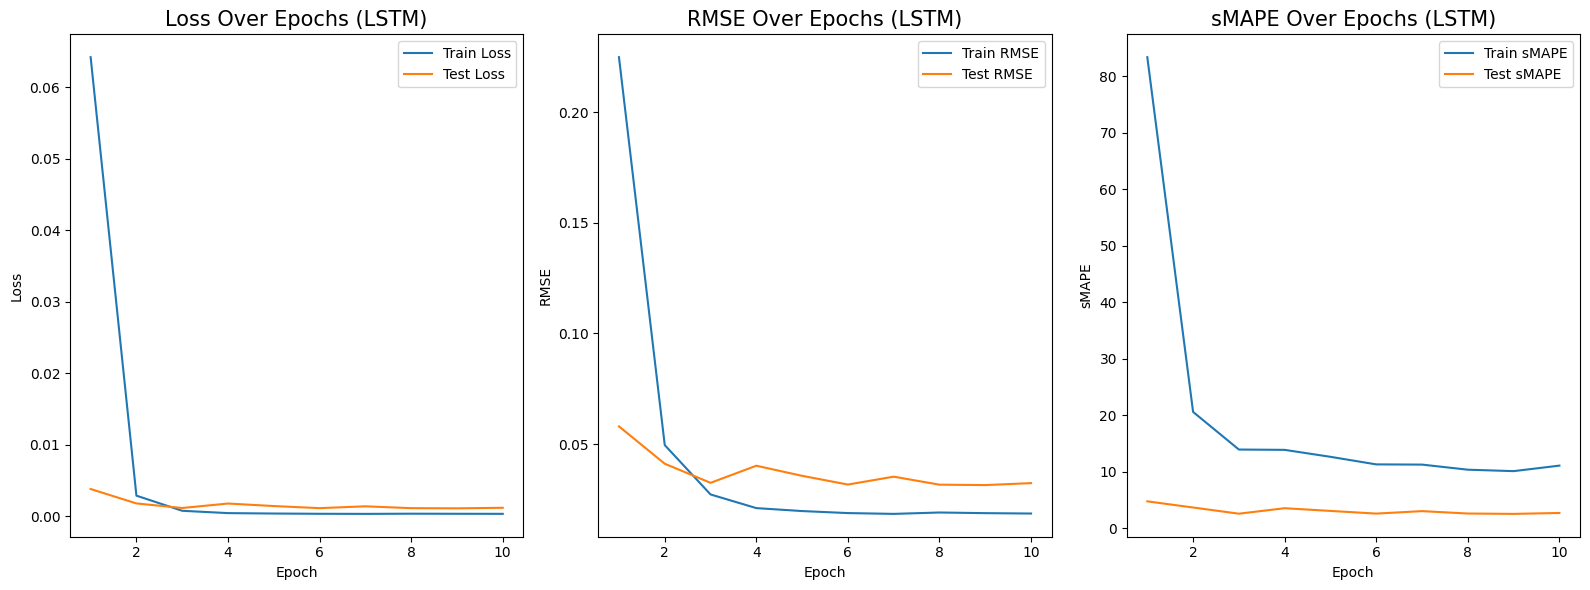

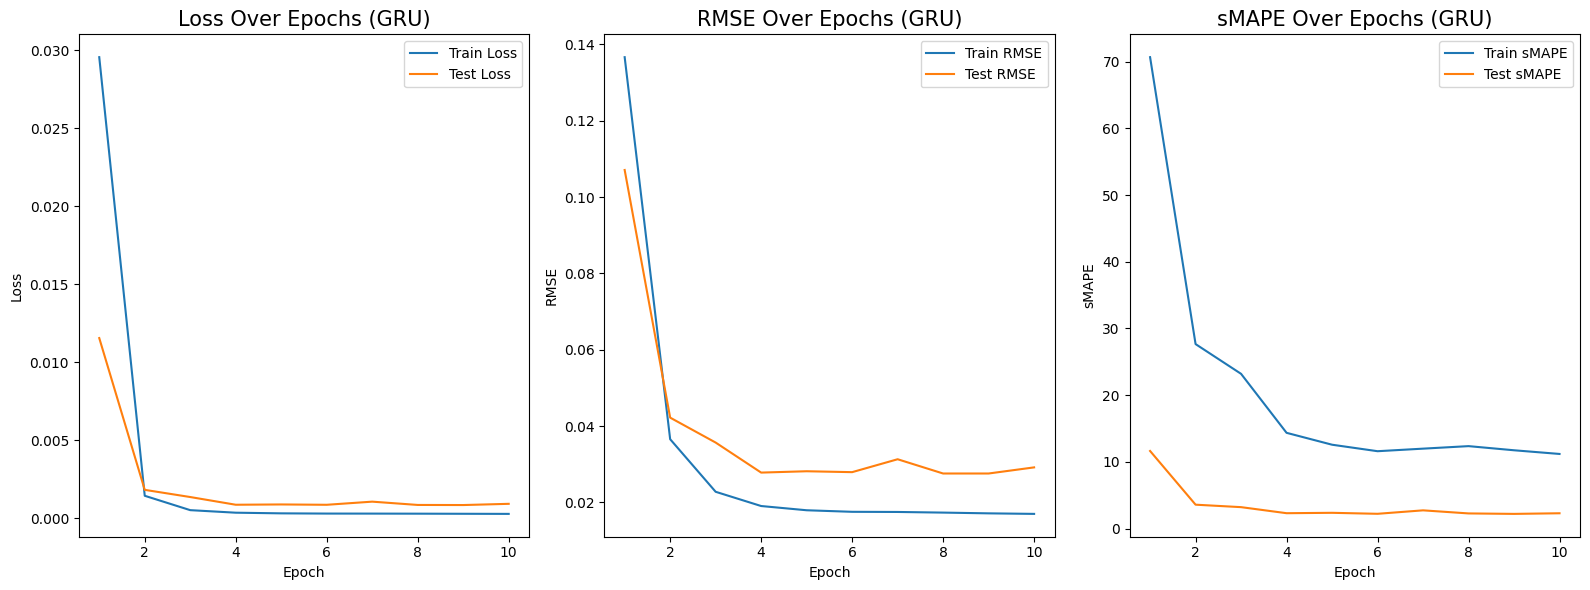

In [24]:
plot_performance("LSTM", EPOCHS, lstm_train_results, lstm_test_results)
plot_performance("GRU", EPOCHS, gru_train_results, gru_test_results)

### Prediction

In [25]:
def make_predictions(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Generate predictions and collect true targets from the DataLoader.

    Args:
        model: Trained PyTorch model for inference.
        data_loader: DataLoader containing the dataset to predict on.
        device: Device to run inference on.

    Returns:
        Tuple:
            all_predictions: NumPy array of all model predictions.
            all_targets: NumPy array of corresponding true targets.
    """
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # Forward pass for predictions
            y_pred, h = model(X, h)
            all_predictions.append(y_pred.cpu())
            all_targets.append(y.cpu())
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    return all_predictions, all_targets

In [26]:
lstm_all_preds, all_actual_y = make_predictions(lstm_model, test_dataloader, device)
lstm_all_preds_unscaled = target_scaler.inverse_transform(lstm_all_preds)
all_actual_y_unscaled = target_scaler.inverse_transform(all_actual_y)

gru_all_preds, _ = make_predictions(gru_model, test_dataloader, device)
gru_all_preds_unscaled = target_scaler.inverse_transform(gru_all_preds)

In [27]:
test_datetimes = df.index[-all_actual_y_unscaled.shape[0] :]

### Visualising Predictions

In [28]:
result_df = pd.DataFrame(
    {
        "datetime": test_datetimes,
        "actual_y": all_actual_y_unscaled.flatten(),
        "lstm": lstm_all_preds_unscaled.flatten(),
        "gru": gru_all_preds_unscaled.flatten(),
    }
)
result_df.set_index("datetime", inplace=True)

print(result_df.head())

              actual_y        lstm         gru
datetime                                      
2024-11-14  227.670807  221.740479  226.095856
2024-11-15  224.458542  221.960281  226.528275
2024-11-18  227.471283  222.128174  226.717972
2024-11-19  227.730667  222.423111  227.145279
2024-11-20  228.448929  222.858429  227.775543


In [29]:
def plot_predictions(results: pd.DataFrame, n_points: int) -> None:
    """
    Plot actual and predicted energy consumption values from LSTM and GRU models.

    Args:
        results: DataFrame containing the columns 'actual_y', 'lstm', and 'gru'.
            The DataFrame index should correspond to the datetime or sequence order.
        n_points: Number of points (time steps) to plot from the results DataFrame.

    Notes:
        The function is intended for quick visual assessment of model performance over time.
        Ensure all values in `results` are unscaled and in physical units (e.g., MW) for meaningful interpretation.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(results["actual_y"][:n_points], label="Actual Values", color="blue")
    plt.plot(
        results["lstm"][:n_points],
        label="LSTM Predictions",
        color="red",
        linestyle="dashed",
    )
    plt.plot(
        results["gru"][:n_points],
        label="GRU Predictions",
        color="orange",
        linestyle="dashed",
    )
    plt.xlabel("Time Step")
    plt.ylabel("Energy Consumption (MW)")
    plt.title("Comparison of Actual vs Predicted Energy Consumption")
    plt.legend()
    plt.tight_layout()
    plt.show()

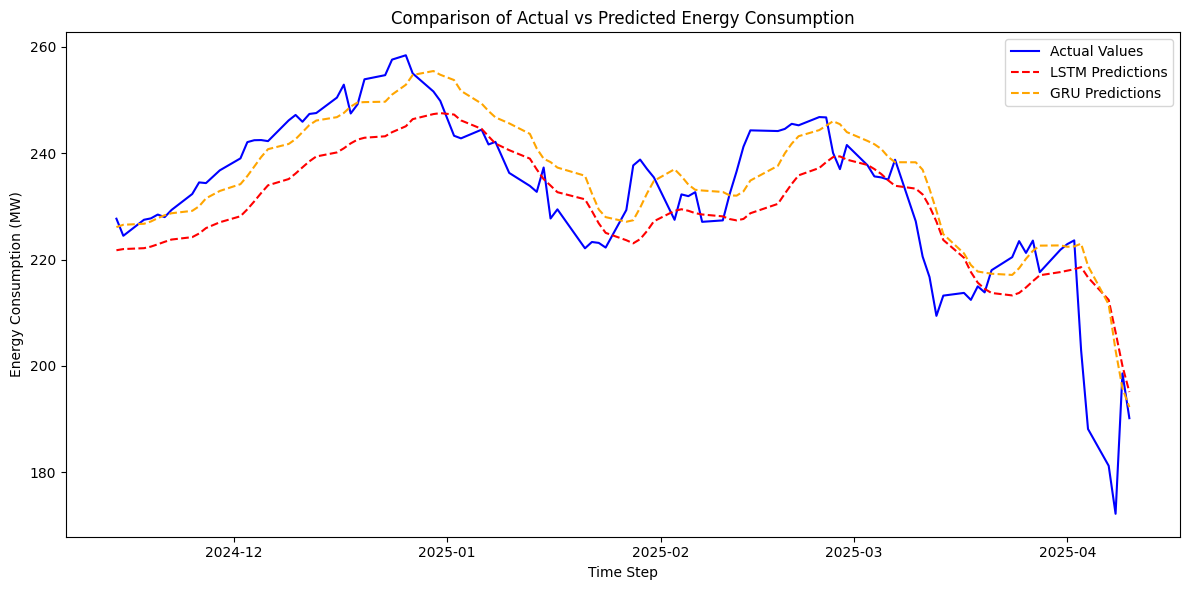

In [31]:
N_points = 100
plot_predictions(result_df, N_points)